In [6]:
from architectures import Generator
from training_gan import plot_samples

import os
import jax
import jax.numpy as jnp
from jax.random import PRNGKey as jkey
from imax import transforms
from chex import Array, Scalar, PRNGKey
import matplotlib.pyplot as plt
from PIL import Image

# Czy sieci neuronowe śnią o ciastach marchewkowych?
## To chyba nie jest oryginalny Breitling, prawda?
Model dyskriminatora:
```python
def conv_block(x: Array, features: int, training: bool) -> Array:

    x = nn.Conv(features=features, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
    x = nn.BatchNorm(use_running_average=not training)(x)
    x = nn.leaky_relu(x, negative_slope=0.2)

    return x


class Discriminator(nn.Module):
    
    @nn.compact
    def __call__(self, batch: Array, training: bool):
        
        batch_size = batch.shape[0]
        x = batch / 255
        x = conv_block(x, 64, training)
        x = conv_block(x, 128, training)
        x = conv_block(x, 128, training)
        x = jnp.reshape(x, (batch_size, -1))
        x = nn.Dropout(rate=0.2, deterministic=not training)(x)
        x = nn.Dense(features=1)(x)
        x = nn.sigmoid(x)
        
        return x
```

## Skoro nie widać różnicy..?
Model generatora:
```python
def trans_conv_block(x: Array, features: int) -> Array:

    x = nn.ConvTranspose(features=features, kernel_size=(4, 4), strides=(2, 2), padding='SAME')(x)
    x = nn.leaky_relu(x, negative_slope=0.2)

    return x


class Generator(nn.Module):

    @nn.compact
    def __call__(self, batch: Array):

        batch_size = batch.shape[0]
        x = batch
        x = nn.Dense(features=8192)(x)
        x = jnp.reshape(x, (batch_size, 8, 8, 128))
        x = trans_conv_block(x, 128)
        x = trans_conv_block(x, 256)
        x = trans_conv_block(x, 512)
        x = nn.Conv(features=3, kernel_size=(5, 5), strides=(1, 1), padding='SAME')(x)
        x = nn.sigmoid(x)

        return x
```

In [14]:
# Generuje fotografie z losowego szumu
model = Generator()
dummy_batch_vectors = jax.random.normal(jkey(42), shape=(2, 128)) * jnp.array([[1], [25]])
vars = model.init(jkey(42), dummy_batch_vectors)
pred = model.apply(
    {'params': vars['params']},
    dummy_batch_vectors
)

Fotografia wygenerowana na podstawie losowego szumu $\mathcal{N}(0, 1)$:

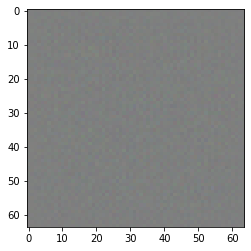

In [12]:
plt.imshow(jnp.squeeze(pred[0]));

Fotografia wygenerowana na podstawie losowego szumu $\mathcal{N}(0, 25)$:

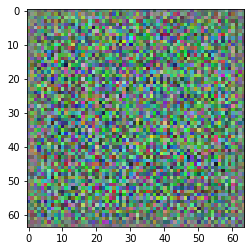

In [13]:
plt.imshow(jnp.squeeze(pred[1]));

## I zebrano jeszcze dwanaście koszy ułomków

In [3]:
raw_galaxies_path = "datasets/galaxies_raw"
files = os.listdir(raw_galaxies_path)
load_galaxy = lambda file: jnp.array(Image.open(os.path.join(raw_galaxies_path, file)).resize((64, 64)))
images = jnp.array(list(map(load_galaxy, files)))

Przykładowe egzemplarze datasetu *galaxies* utworzonego z uyciem biblioteki *jmd_imagescraper*:

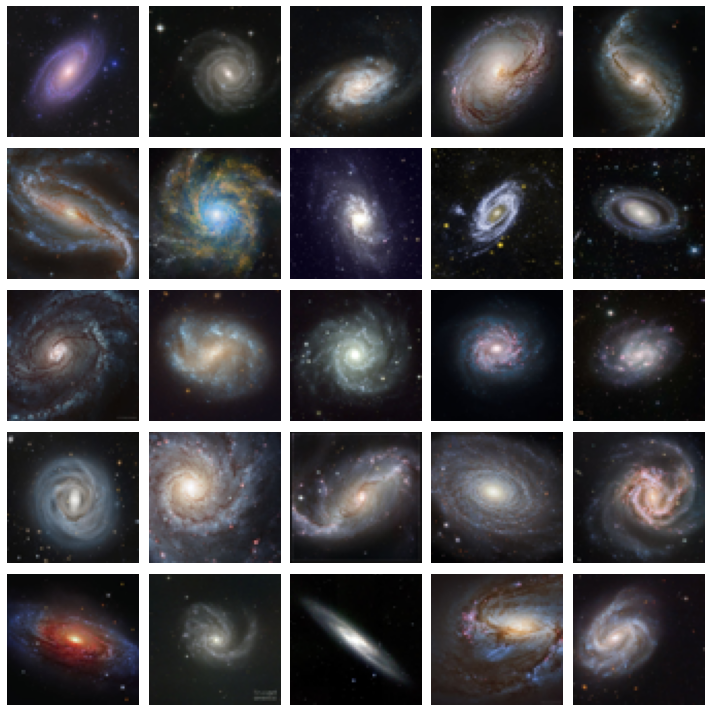

In [5]:
plot_samples(images, subplots_shape=(5, 5))

### Data augmentation
Do operacji "data augmentation" skorzystałem z bibliotki *imax*, która zapewnia mi potrzebne transformacje (odbicia, rotacje, translacje i skalowanie). Ponizszy kod przedsawia stochastyczną modyfikację pojedynczego obrazka:

In [7]:
def augmentat_img(img, key: PRNGKey):

    key_1, key_2, key_3, key_4, key_5, key_6 = jax.random.split(key, 6)

    rot = transforms.rotate(
        rad=jax.random.uniform(key_1, minval=-jnp.pi / 8, maxval=jnp.pi / 8)
    )
    flip = transforms.flip(
        jax.random.uniform(key_2) < 0.5,
        jax.random.uniform(key_3) < 0.5
    )
    scale = transforms.scale(
        jax.random.uniform(key_4, minval=1.0, maxval=1.5),
        jax.random.uniform(key_4, minval=1.0, maxval=1.5)
    )
    translate = transforms.translate(
        jax.random.uniform(key_5, minval=-8.0, maxval=8.0),
        jax.random.uniform(key_6, minval=-8.0, maxval=8.0)
    )

    return transforms.apply_transform(img, flip @ rot @ translate @ scale, mask_value=-1)

Data augmentation na małym zbiorze danych (5-elementowym):

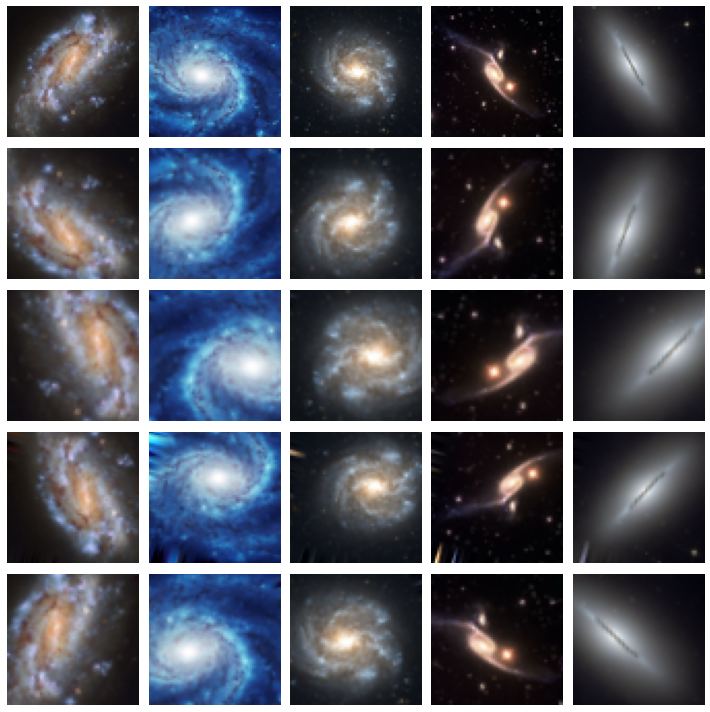

In [8]:
small_ds = images[:5]

keys = jax.random.split(jkey(42), 4)
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(10, 10)
for i in range(5):
    ax = axes[0, i]
    ax.imshow(small_ds[i])
    ax.axis('off')
for j in range(4):
    for i in range(5):
        ax = axes[1 + j, i]
        ax.imshow(augmentat_img(small_ds[i], keys[j]))
        ax.axis('off')
fig.tight_layout()
plt.show()